In [157]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,prange
from copy import deepcopy
#import minimize_protein as mp
import recursive_proteins as rp
import pandas as pd
import imp

### Create synthetic dataset

It is important to note that when we create a dataset it must be close to reality in the sense that the approximations we use (for the GFP) holds! For example we assume growth is almost linear so we cannot create too long cells since the exponential evvects will start to play a major role and make our predictions wrong!

In [263]:
imp.reload(rp)

<module 'recursive_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/recursive_proteins.py'>

In [748]:
length_min = 60 #10 cell cycle
dt = 0.1 # dt for simulations
ncel=500#one lane ID
# log_length production lambda
ml=0.0116;gl=0.0156;sl2=2.15e-07
L = rp.ornstein_uhlenbeck(ml,gl,sl2,length_min,ncel,dt)
# mRNA fraction fluctuations (cv=20%) 
mq=20;gq=1/20;sq2=(0.4)**2*2*gq*mq**2
Q = rp.ornstein_uhlenbeck(mq,gq,sq2,length_min,ncel,dt)
# Noisy and not noisy length X and Xnn
sx2=0.00034
X,Xnn,_ = rp.log_length_synth(L,sx2,dt)
# Noisy GFP (3%noise) lose 0.03 % of protein every minute 
G0=1000; beta=0.003; sg2=5317
G,Gnn = rp.protein_prod(Q,Xnn,G0,beta,sg2,dt)

In [749]:
L,Q,G,Gnn,Xnn,X = [rp.sampling_from_path(mat,0.1,3) for mat in [L,Q,G,Gnn,Xnn,X]]

### See predicted covariance matrix with this dataset

In [767]:
imp.reload(rp)

<module 'recursive_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/recursive_proteins.py'>

In [662]:
def mean_cov_t(Xnn,L,G,Q,t):
    m0 = np.mean(Xnn[:,t]);m1=np.mean(L[:,t]);m2=np.mean(G[:,t]);m3=np.mean(Q[:,t])
    C00 = np.var(Xnn[:,t]); C01 = np.cov(Xnn[:,t],L[:,t])[0,1];C02 = np.cov(Xnn[:,t],G[:,t])[0,1];C03 = np.cov(Xnn[:,t],Q[:,t])[0,1]
    C11 = np.var(L[:,t]); C12 = np.cov(L[:,t],G[:,t])[0,1]; C13 = np.cov(L[:,t],Q[:,t])[0,1]
    C22 = np.var(G[:,t]) ; C23 = np.cov(G[:,t],Q[:,t])[0,1] ; C33 = np.var(Q[:,t])
    return m0,m1,m2,m3,C00,C01,C02,C03,C11,C12,C13,C22,C23,C33

In [663]:
t=10
m0,m1,m2,m3,C00,C01,C02,C03,C11,C12,C13,C22,C23,C33 = mean_cov_t(Xnn,L,G,Q,t) #STARTING MEAN AND COV
delta_t=1 # PREDICT AFTER DELTA_T
nm,nQ = rp.new_mean_cov(m0,m1,m2,m3,C00,C01,C02,C03,C11,C12,C13,C22,C23,C33,ml,gl,sl2,mq,gq,sq2,delta_t,beta)
nm0,nm1,nm2,nm3,nC00,nC01,nC02,nC03,nC11,nC12,nC13,nC22,nC23,nC33 = mean_cov_t(Xnn,L,G,Q,t+delta_t)
nQ00,nQ01,nQ02,nQ03,nQ11,nQ12,nQ13,nQ22,nQ23,nQ33 = nQ

In [664]:
print(nm)
print(nm0,nm1,nm2,nm3)

(0.36108810813013353, 0.011613315847601724, 1627.04723516676, 20.02719974254827)
0.38431213011538934 0.01161647754751362 1676.889304411341 20.034903074629142


In [665]:
print(nC00,nC01,nC02,nC03,"\n",nC11,nC12,nC13,"\n",nC22,nC23,"\n",nC33)
print("space")
print(nQ00,nQ01,nQ02,nQ03,"\n",nQ11,nQ12,nQ13,"\n",nQ22,nQ23,"\n",nQ33)

1.9105743414743825e-05 7.58171011288095e-07 0.009522880015705653 8.891061961894846e-05 
 4.661627487733841e-08 0.0006138090414418966 9.575169876792753e-06 
 6531.993954018068 15.636286807816212 
 0.45521446494555257
space
1.6271702138263788e-05 8.016235513253073e-07 0.029614844149430934 5.220412298956528e-05 
 2.5369804103344567e-07 0.0013907073315750028 5.491854598291339e-06 
 5845.706916693022 8.474156582588737 
 2.9067144315558435


### Check posteriors

In [751]:
imp.reload(rp)

<module 'recursive_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/recursive_proteins.py'>

In [752]:
sxd2=sgd2=0; dt=3

In [753]:
import recursive_lengths as rl

In [754]:
#80
cell=10
time0=10
W_tot = np.vstack((Xnn[cell,time0:],L[cell,time0:],Gnn[cell,time0:],Q[cell,time0:])).T
W=np.vstack((X[cell,time0:],G[cell,time0:])).T

In [755]:
s0,s1,s2,s3,S00,S01,S02,S03,S11,S12,S13,S22,S23,S33 =  mean_cov_t(Xnn,L,Gnn,Q,time0)
IS00,IS01,IS02,IS03,IS11,IS12,IS13,IS22,IS23,IS33 = rp.inverseQ(S00,S01,S02,S03,S11,S12,S13,S22,S23,S33)

In [756]:
zrl,err_zrl,_,_ = rl.predictions_1cc(W[:,:1].T,ml,gl,sl2,sx2,sd2=sx2,dt=1,s=np.array([[s0],[s1]]),S=np.array([[S00,S01],[S01,S11]]),rescale=1)
zrl= np.hstack(zrl).T
err_zrl = np.vstack(err_zrl)

In [757]:
z_vec,err_z_vec,_,_ = rp.predictions_1cc(W,ml,gl,sl2,mq,gq,sq2,sx2,sg2,sxd2,sgd2,s0,s1,s2,s3,IS00,IS01,IS02,IS03,IS11,IS12,IS13,IS22,IS23,IS33,dt,beta)
z_vec = np.vstack(z_vec)
err_z_vec = np.vstack(err_z_vec)

In [758]:
t= np.arange(W_tot[:,0].shape[0])

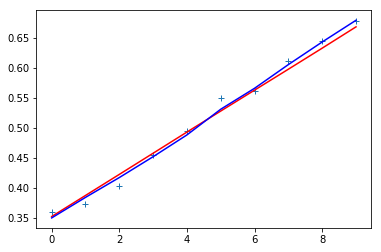

In [759]:
plt.plot(t,(W[:,0]),'+')
plt.plot(t,W_tot[:,0],'r')
plt.plot(t,z_vec[:,0],'b')


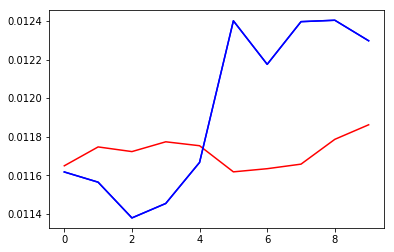

In [764]:
plt.plot(t,W_tot[:,1],'r')
plt.plot(t,z_vec[:,1],'b')
plt.plot(t,z_vec[:,1],'b')
#plt.plot(t,zrl[:,1],'g')

In [742]:
from scipy.stats import linregress

In [743]:
sliding = lambda siz,W: [ linregress(np.arange(siz),np.log(W[i:i+siz].reshape(-1))).slope for i in range(W.shape[0]-siz)]


In [744]:
slidingL_log = sliding(3,W[:,0])

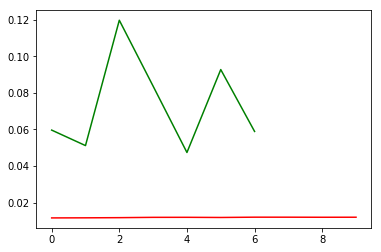

In [745]:
plt.plot(t,W_tot[:,1],'r')
plt.plot(t[:-3],slidingL_log,'g')

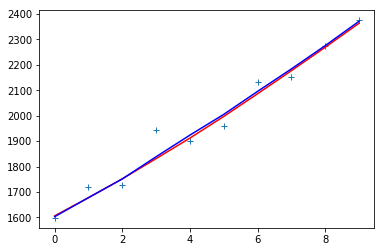

In [765]:
a=0;b=200
plt.plot(t[a:b],W[a:b,1],'+')
plt.plot(t[a:b],W_tot[a:b,2],'r')
plt.plot(t[a:b],z_vec[a:b,2],'b')


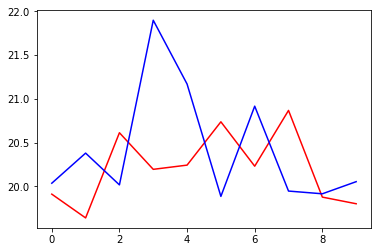

In [766]:
plt.plot(t,W_tot[:,3],'r')
plt.plot(t,z_vec[:,3],'b')



In [686]:
min(Q.reshape(-1))

17.741665644292453

from scipy.stats import linregress

In [752]:
slidingQ_log = [ linregress(np.arange(3),np.log(W[i:i+3,1].reshape(-1))).slope for i in range(W.shape[0]-3)]
slidingQ = [ linregress(np.arange(3),W[i:i+3,1].reshape(-1)).slope for i in range(W.shape[0]-3)]


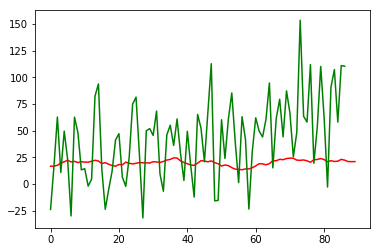

In [753]:
plt.plot(t,W_tot[:,3],'r')
plt.plot(t[:-3],slidingQ,'g')

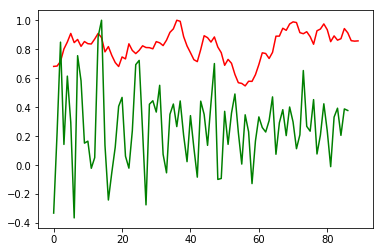

In [754]:
#IF we take the long 
plt.plot(t,W_tot[:,3]/(max(W_tot[:,3])),'r')
plt.plot(t[:-3],slidingQ_log/max(slidingQ_log),'g')

## Test likelihood

In [770]:
import minimize_proteins as mp

In [802]:
df = pd.read_csv('/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glucose.csv')
df = df.loc[df['lane_ID']=='myframes_chr_hi1_glucose_2019051507']

In [892]:
imp.reload(rp)

<module 'recursive_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/recursive_proteins.py'>

In [893]:
_,in_dic =  rp.build_data_strucutre(df,'length_um','gfp_nb',0.003)

In [910]:
in_dic['par_len'] = {'ml':0.011643521097147237, 'gl':0.015546112165454942, 'sl2':2.1386677870471331e-07, 'sx2': 0.0003439092082195258,'sdx2':in_dic['sdx2']}

In [919]:
mod.tot_grad_obj((164,0.01,2000,in_dic['sg2'],in_dic['sdg2'],0.003),in_dic)

7.650730860660172

In [916]:
imp.reload(rp)

<module 'recursive_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/recursive_proteins.py'>

In [929]:
imp.reload(mp)

<module 'minimize_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/minimize_proteins.py'>

In [930]:
mod = mp.minimize_protein(free={'sigma2':2000,'mean':164,'sm2':560017,'gamma':0.01,'sgd2':560017,'b':0.003},fixed={})


In [931]:
mod.minimize(in_dic)

TypeError: <lambda>() takes 3 positional arguments but 4 were given

In [768]:
lik = lambda x: rp.obj_and_grad_1cc(W,ml,gl,sl2,x[0],x[1],x[2],sx2,x[3],sxd2,sgd2,s0,s1,s2,s3,IS00,IS01,IS02,IS03,IS11,IS12,IS13,IS22,IS23,IS33,dt,b)[0]

In [769]:
minimize(lik,(mq,gq,sq2,sg2),method='L-BFGS-B',constraints=([(1e-10,1e10)*4]))

NameError: name 'minimize' is not defined

In [795]:
lik((mq+10000,gq,sq2,sg2))

-736157505.7732329

In [ ]:
684902233

In [791]:
lik((2.00064492e+01, 2.10176523e+01, 4.34880393e-01, 2.50000364e+03))

-1296553710913.5662

# Predictions on GFP (still have to fix the log likelihood but want to clean Theo dataset)

In [796]:
df = pd.read_csv('/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glucose.csv')

In [1197]:
df = df.loc[df['lane_ID']=='myframes_chr_hi1_glucose_2019051502']

In [800]:
import recursive_proteins as rp

In [1199]:
ddf, in_dic = rp.build_data_strucutre(df,'length_um','gfp_nb',0.003)

In [1230]:
imp.reload(rp)

<module 'recursive_proteins' from '/scicore/home/nimwegen/fiori/MoMA_predictions/recursive_proteins.py'>

In [1250]:
np.sqrt(300/(2*0.03))/140

0.5050762722761054

In [1251]:
par_prot= 140,0.03, 200,165349,165349,0.003
par_len = 0.01165,0.020734639,2.595e-07,0.000374,0.00439
X = rp.predict(par_prot,par_len,in_dic)

In [1252]:
fin = rp.merge_df_pred(ddf,X)

myframes_chr_hi1_glucose_2019051502133 127


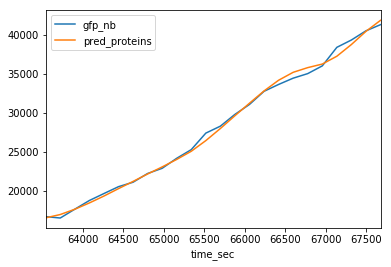

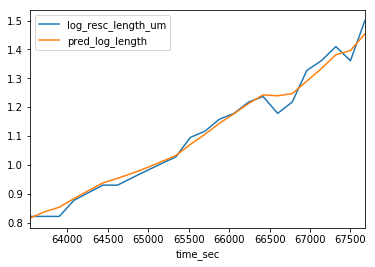

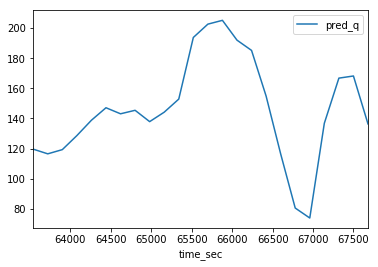

In [1257]:
ce=35
print(fin.cell.unique()[ce],fin.loc[fin['cell']==fin.cell.unique()[ce]].parent_id.iloc[0])
fin.loc[fin['cell']==fin.cell.unique()[ce]].plot(x='time_sec',y=['gfp_nb','pred_proteins'])
fin.loc[fin['cell']==fin.cell.unique()[ce]].plot(x='time_sec',y=['log_resc_length_um','pred_log_length'])
fin.loc[fin['cell']==fin.cell.unique()[ce]].plot(x='time_sec',y='pred_q')

In [1227]:
W = fin.loc[fin['cell']==fin.cell.unique()[1]][['log_resc_length_um','gfp_nb']].values

Try with rl algorithm

In [1035]:
df_, in_dicrl = rl.build_data_strucutre(df,'length_um',1)

In [1106]:
min_dic = {'best_param':{'mlam':0.01165,'gamma':0.020734639,'sl2':2.595e-07,'sm2':0.000374}}
Y = rl.predict(min_dic,in_dicrl)

In [1114]:
ddf_ = rl.merge_df_pred(df_,Y)

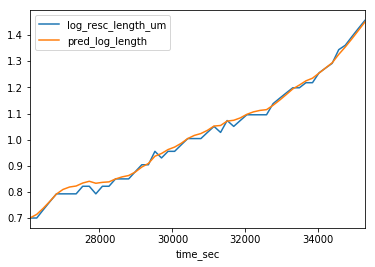

In [1126]:
ddf_.loc[ddf_['cell']=='myframes_chr_hi1_glucose_2019051501355'].plot(x='time_sec',y=['log_resc_length_um','pred_log_length'])

In [1044]:
in_dicrl['sd2']

0.004675380441939467

## todelelte


In [7]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [932]:
df = pd.read_csv('/scicore/home/nimwegen/gervais/MoM_StatPhase/GAUSSIAN_SMOOTHING/gfp_nb_ATHOS_1342.csv')


In [ ]:
20191018.0.11.69

In [933]:
df['cell'].unique()[80]

'20191018_16_5_80'

In [934]:
x = df.loc[df['cell']=='20191018_0_11_69']

In [935]:
pr = x['gfp_nb_pred'][::3]
t= np.arange(len(pr))
y = x['gfp_nb'][:len(pr)]
pr1 = x['d_gfp_nb_dt'][::3]

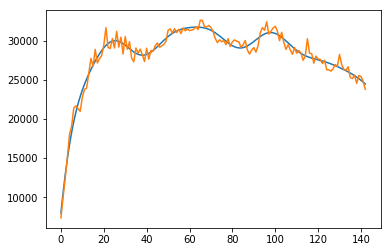

In [936]:

plt.plot(t,pr)
plt.plot(t,y)

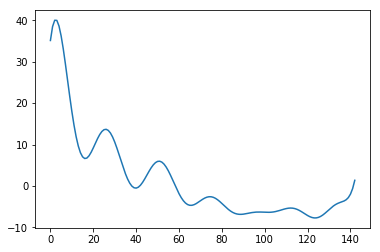

In [707]:
plt.plot(t,pr1)

In [712]:
dfl.columns

Index(['Unnamed: 0', 'cell', 'd_length_moma_dt', 'err', 'length_moma',
       'length_moma_pred', 'time'],
      dtype='object')

In [938]:
dfl = pd.read_csv('/scicore/home/nimwegen/gervais/MoM_StatPhase/GAUSSIAN_SMOOTHING/length_moma_ATHOS_1342.csv')
x = dfl.loc[dfl['cell']=='20191018_0_11_69']
pr = x['length_moma_pred'][::3]
t= np.arange(len(pr))
y = x['length_moma'][:len(pr)]
pr1 = x['d_length_moma_dt'][::3]

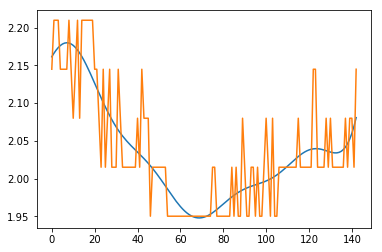

In [939]:

plt.plot(t,pr)
plt.plot(t,y)

In [942]:
dfl['time']

0          0.0
1          1.0
2          2.0
3          3.0
4          4.0
5          5.0
6          6.0
7          7.0
8          8.0
9          9.0
10        10.0
11        11.0
12        12.0
13        13.0
14        14.0
15        15.0
16        16.0
17        17.0
18        18.0
19        19.0
20        20.0
21        21.0
22        22.0
23        23.0
24        24.0
25        25.0
26        26.0
27        27.0
28        28.0
29        29.0
          ... 
698382     NaN
698383     NaN
698384     NaN
698385     NaN
698386     NaN
698387     NaN
698388     NaN
698389     NaN
698390     NaN
698391     NaN
698392     NaN
698393     NaN
698394     NaN
698395     NaN
698396     NaN
698397     NaN
698398     NaN
698399     NaN
698400     NaN
698401     NaN
698402     NaN
698403     NaN
698404     NaN
698405     NaN
698406     NaN
698407     NaN
698408     NaN
698409     NaN
698410     NaN
698411     NaN
Name: time, Length: 698412, dtype: float64

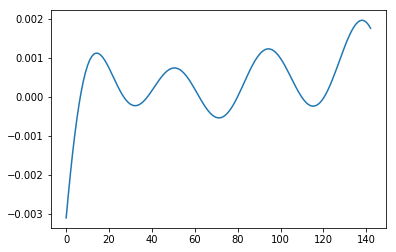

In [734]:
plt.plot(t,pr1)
